# AEWS Python Notebook

## Preliminaries

This iPython notebook is to test the basic functionality of AGDC v2 API for AEWS project. For info, an iPython notebook represents a tool to integrate Python code with comments and results, in a way that makes it convenient for programmers to document their code and results, and for others to follow the developments. The bulk of the Python code contained in a notebook (such as the one presented below) can be typically extracted from the notebook and batched up into a .py script for operational and large-scale execution, e.g. on the NCI.

This (Jupyter) notebook is intended for use on the NCI's VDI system, where the following module has been pre-loaded:
```
$ module use /g/data/v10/public/modules/modulefiles --append
$ module load agdc-py2-dev
```
This somewhat matters as the file system visible / accessible from the VDI is different from that available on the NCI. All Python code developed on the VDI should however be able to run seamlessly as batch job on the NCI.

**Note:** The Python code below is "rudimentary". It does not make use of the API's Analytics / Execution Engines, nor is it optimised to take advantage of the subtleties of Python's `xarray`s, etc. Priority is here given to code  interpretability rather than execution efficiency.

Let's begin with standard Python declarations and import statements:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

from pylab import rcParams
rcParams['figure.figsize'] = 11, 11   # increase plot size a bit...

# here we import the AGDC v2 API, having loaded the 'agds-py2-dev' (or similar) module prior to starting the notebook
import datacube.api

Let's see what AGDC v2.0 datasets (netCDF) are available in the NCI database. By default, the API uses the configured database connection found in a configuration file. Typically, this can be checked from a terminal shell using:
```
$ datacube-config check
$ printenv DATACUBE_CONFIG_PATH
```
The latter command typically returns:
```
/g/data/v10/public/modules/agdc-py2-dev/1.0.2+20.g368a323/datacube.conf
```
which points to EO tiles located under:
```
/g/data/u46/public/datacube/data/
```
The `/g/data/` mount is visible to both the NCI and the VDI system, so this AGDC data is accessible from both (or similarly, the AGDC data on VDI is the same as that accessible on the NCI).

Currently (March 2016), only a limited AGDC v2.0 database is available on the NCI. We know this includes data for a ~long temporal window for a region around Lake Burley-Griffin, and one year for the whole-of-Australia. In any case, more datasets (e.g. Landsat 8 geoTiff's) can be "ingested" in a local database / cube for demo purposes if necessary.

## Checking available datasets

Use the functions `list_fields()` and `list_field_values(field)` to list all the fields that can be searched and their values found in the database.

In [2]:
dc = datacube.api.API()
dc.list_fields()

[u'product',
 u'lat',
 u'sat_path',
 u'platform',
 u'lon',
 u'orbit',
 'collection',
 u'instrument',
 u'sat_row',
 u'time',
 u'gsi',
 'id']

In [3]:
print( dc.list_field_values('product') )
print( dc.list_field_values('platform') )
print( dc.list_field_values('collection') )
print( dc.list_field_values('instrument') )

[u'PQ', u'NBAR']
[u'LANDSAT_5']
[u'eo']
[u'TM']


So the NCI database here only contains data from LS5 currently.

## Data query
First let's make a query and find out specifics about the whole dataset.

In [4]:
# query as Python dictionary:
query = {
    'product': 'NBAR',
    'platform': 'LANDSAT_5',
}
desc = dc.get_descriptor(query, include_storage_units=False)
pprint(desc)

{u'ls5_nbar_albers': {'dimensions': [u'time', u'y', u'x'],
                      'irregular_indices': {u'time': array(['1990-03-03T10:11:16.000000000+1100',
       '1990-03-03T10:11:39.000000000+1100',
       '1990-04-04T09:10:42.000000000+1000', ...,
       '1996-11-14T10:11:26.000000000+1100',
       '1996-11-30T10:11:47.000000000+1100',
       '1996-11-30T10:12:11.000000000+1100'], dtype='datetime64[ns]')},
                      'result_max': (numpy.datetime64('1996-11-30T10:12:11.000000000+1100'),
                                     -1100012.5,
                                     2299987.5),
                      'result_min': (numpy.datetime64('1990-03-03T10:11:16.000000000+1100'),
                                     -4999987.5,
                                     -1999987.5),
                      'result_shape': (1051, 156000, 172000),
                      'variables': {u'band_10': {'datatype_name': dtype('int16'),
                                                 'nodata_va

This tells us that LS5 NBAR data is available in Albers projection for 1051 time slices between 1990-03-03 and 1996-11-30. The extents of the available dataset is between Northing/Easting top-right corner (-1100012.5,2299987.5) and bottom-left corner (-4999987.5,-1999987.5), which should be the whole of Australia. Of course, not all 1051 time slices cover the whole of this extent! The extent has a total of 156000 x 172000 pixels (@ 25m):

In [5]:
print( (-1100012.5 - -4999987.5 + 25)/25 )
print( (2299987.5 - -1999987.5 + 25)/25 )

156000.0
172000.0


The correspondence of bands is more cryptic. The AGDC v2.0 API is currently missing a semantics layer to be able to use alias for band names. So for now, we have to rely on the knowledge that:

* `band_10` is blue -- LS band 1
* `band_20` is green -- LS band 2
* `band_30` is red -- LS band 3
* `band_40` is NIR -- LS band 4
* `band_50` is SWIR 1 -- LS band 5
* `band_70` is SWIR 2 -- LS band 7

This is obviously subject to change in the near future.

Now let's do a more specific search, for some random locations across Australia:

In [6]:
# Uluru:
query = {
    'product': 'NBAR',
    'platform': 'LANDSAT_5',
    'dimensions': {
        'x' : { 'range': (131.0, 131.1) },
        'y' : { 'range': (-25.3, -25.4) }
    }
}
desc = dc.get_descriptor(query, include_storage_units=False)
print( desc['ls5_nbar_albers']['result_min'][0] )
print( desc['ls5_nbar_albers']['result_max'][0] )

1990-06-02T10:28:01.000000000+1000
1990-07-27T10:34:29.000000000+1000


In [7]:
# Bungle Bungles
query = {
    'product': 'NBAR',
    'platform': 'LANDSAT_5',
    'dimensions': {
        'x' : { 'range': (128.3, 128.4) },
        'y' : { 'range': (-17.4, -17.5) }
    }
}
desc = dc.get_descriptor(query, include_storage_units=False)
print( desc['ls5_nbar_albers']['result_min'][0] )
print( desc['ls5_nbar_albers']['result_max'][0] )

1990-06-07T10:44:34.000000000+1000
1990-07-25T10:44:27.000000000+1000


In [8]:
# Cradle Mountain:
query = {
    'product': 'NBAR',
    'platform': 'LANDSAT_5',
    'dimensions': {
        'x' : { 'range': (145.9, 146.0) },
        'y' : { 'range': (-41.6, -41.7) }
    }
}
desc = dc.get_descriptor(query, include_storage_units=False)
print( desc['ls5_nbar_albers']['result_min'][0] )
print( desc['ls5_nbar_albers']['result_max'][0] )

1990-06-07T09:12:28.000000000+1000
1990-07-25T09:12:45.000000000+1000


OK, so it appears that the current OZ-wide LS5 dataset on the NCI has time slices during June-July 1990.

Let's now have a look at the LBG area...

In [9]:
# LBG:
query = {
    'product': 'NBAR',
    'platform': 'LANDSAT_5',
    'dimensions': {
        'x' : { 'range': (148.7, 149.5) },
        'y' : { 'range': (-35.0, -35.5) }
    }
}
desc = dc.get_descriptor(query, include_storage_units=False)
# pprint(desc)
print( desc['ls5_nbar_albers']['result_min'][0] )
print( desc['ls5_nbar_albers']['result_max'][0] )
print( desc['ls5_nbar_albers']['result_shape'][0] )

1990-03-03T10:11:16.000000000+1100
1996-11-30T10:12:11.000000000+1100
182


We have 182 time slices between a ~7 year period, 1990-03-03 to 1996-11-30.

## Data access
There are different ways to load up actual Landsat data. 

**Data access method 1:** Let's have a look at `get_data()`...

In [10]:
query = {
    'product': 'NBAR',
    'platform': 'LANDSAT_5',
    'dimensions': {
        'x' : { 'range': (149.0, 149.22) },
        'y' : { 'range': (-35.22, -35.38) },
        'time': { 'range': ((1996, 1, 1), (1996, 7 ,1)) }
    }
}
L5data = dc.get_data( query )       # returns a dictionary
# pprint(L5data)

The command returns a Python dictionary, where various variables can be accessed as follows:

In [11]:
print( type(L5data) )
print( L5data.keys() )
print( L5data['dimensions'] )
print( L5data['element_sizes'][1:3] )     # x/y pixel size
print( L5data['indices']['time'] )        # time indices
print( L5data['size'] )                   # time,x,y sizes/lengths

<type 'dict'>
['dimensions', 'arrays', 'element_sizes', 'indices', 'coordinate_reference_systems', 'size']
[u'time', u'y', u'x']
[24.9692118226601, 24.971815107102593]
['1996-01-31T09:54:41.500000000+1100' '1996-01-31T09:55:05.500000000+1100'
 '1996-02-16T09:56:11.000000000+1100' '1996-03-03T09:57:15.500000000+1100'
 '1996-04-04T08:58:54.000000000+1000' '1996-04-04T08:59:18.000000000+1000'
 '1996-04-20T08:59:53.000000000+1000' '1996-04-20T09:00:17.000000000+1000'
 '1996-05-22T09:01:46.000000000+1000' '1996-05-22T09:02:10.000000000+1000'
 '1996-06-07T09:02:40.000000000+1000']
(11, 812, 887)


In [12]:
# whole of band_1, all pixels and all dates
L5data['arrays']['band_10']

<xarray.DataArray u'band_10' (time: 11, y: 812, x: 887)>
dask.array<getitem..., shape=(11, 812, 887), dtype=int16, chunksize=(11, 812, 887)>
Coordinates:
  * time     (time) datetime64[ns] 1996-01-30T22:54:41.500000 ...
  * y        (y) float64 -3.949e+06 -3.949e+06 -3.949e+06 -3.949e+06 ...
  * x        (x) float64 1.537e+06 1.537e+06 1.537e+06 1.537e+06 1.538e+06 ...

In [13]:
# LS5 band_1 data for one/first date
L5data['arrays']['band_10'].isel(time=0).values

array([[ 852,  808,  806, ...,  741,  731,  740],
       [ 810,  815,  829, ...,  694,  699,  712],
       [ 784,  797,  810, ...,  677,  692,  675],
       ..., 
       [-999, -999, -999, ..., -999, -999, -999],
       [-999, -999, -999, ..., -999, -999, -999],
       [-999, -999, -999, ..., -999, -999, -999]], dtype=int16)

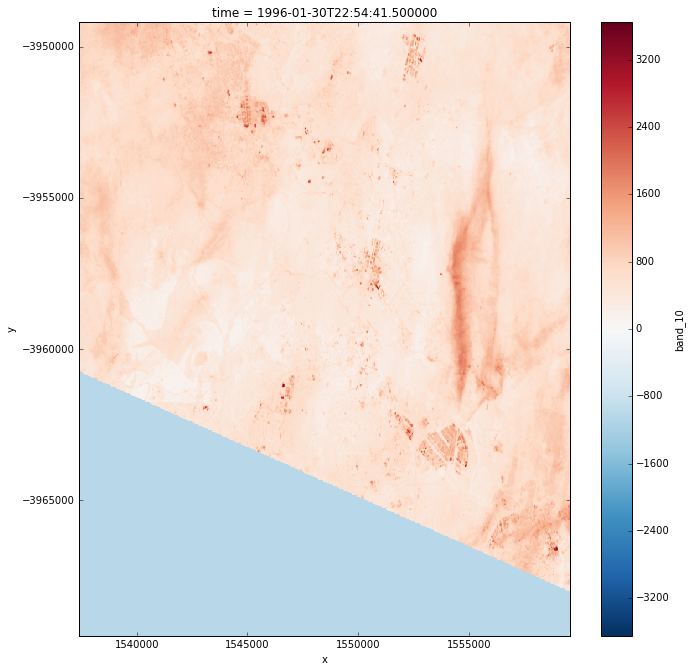

In [14]:
# LS5 band_1 data plot for first date
L5data['arrays']['band_10'].isel(time=0).plot()

Looks somewhat cloudy perhaps, but we've got some data! Let's try to get a better display style (e.g. bands 5/4/3 in R/G/B)... and a different date!

In [15]:
date_ind = 6
B2data = L5data['arrays']['band_20'].isel(time=date_ind).values    # numpy.ndarray
B4data = L5data['arrays']['band_40'].isel(time=date_ind).values
B5data = L5data['arrays']['band_50'].isel(time=date_ind).values

Let's create a basic function to normalise and scale the data for displaying:

In [16]:
def scale_array(arr, prcnt, min_val, max_val, nan_val):
    # Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val' and 'max_val', 
    # replacing 'nan_val' values with NaN's.
    f_arr = arr.astype('float')    # required for NaN's 
    f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    return f_arr

Let's scale our band_2 data (and check the result!)...

In [17]:
print(B2data); print "\n"      # original array
sB2data = scale_array(B2data, 99.0, 0, 255, -999)
print( sB2data ); print "\n"   # scaled array
print( np.nanmin(sB2data), np.nanmax(sB2data) )   # scaled array extents

[[ 487  651  649 ...,  837  887  829]
 [ 417  495  505 ...,  770  865  880]
 [ 410  404  432 ...,  651  778  838]
 ..., 
 [-999 -999 -999 ..., -999 -999 -999]
 [-999 -999 -999 ..., -999 -999 -999]
 [-999 -999 -999 ..., -999 -999 -999]]


[[  55.96153846   79.61538462   79.32692308 ...,  106.44230769
   113.65384615  105.28846154]
 [  45.86538462   57.11538462   58.55769231 ...,   96.77884615
   110.48076923  112.64423077]
 [  44.85576923   43.99038462   48.02884615 ...,   79.61538462
    97.93269231  106.58653846]
 ..., 
 [          nan           nan           nan ...,           nan
            nan           nan]
 [          nan           nan           nan ...,           nan
            nan           nan]
 [          nan           nan           nan ...,           nan
            nan           nan]]


(0.0, 255.0)


Seems to work OK... Now let's create our display:

In [18]:
sB4data = scale_array(B4data, 99.0, 0, 255, -999)
sB5data = scale_array(B5data, 99.0, 0, 255, -999)
y_size = L5data['size'][1]
x_size = L5data['size'][2]

In [19]:
# False colour image, using integers for better compatibility with plt.imshow()
FC_image = np.zeros((y_size, x_size, 3), dtype='uint8')
FC_image[:,:,0] = sB5data
FC_image[:,:,1] = sB4data
FC_image[:,:,2] = sB2data

In [20]:
FC_image[:,:,0]

array([[127, 137, 162, ..., 193, 181, 179],
       [114, 105, 120, ..., 187, 181, 179],
       [111, 110, 122, ..., 182, 181, 180],
       ..., 
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

Using integer values means that all NaN's have been replaced by 0's. Not a big deal if we're only dealing with display purposes (the NaN's will appear in black).

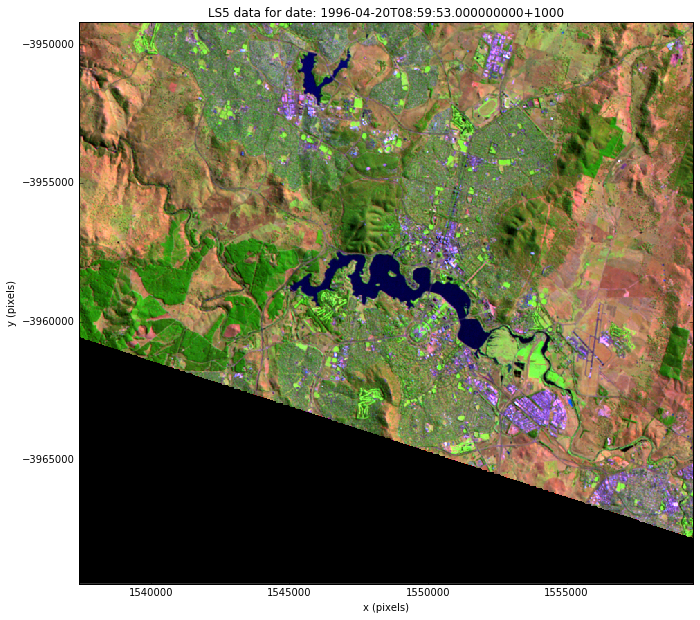

In [21]:
cur_date = L5data['indices']['time'][date_ind]
xvec = L5data['indices']['x']
yvec = L5data['indices']['y']
plt.imshow(FC_image, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
#plt.axis('image')
plt.title('LS5 data for date: {}'.format(cur_date))
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')

Nice!...

**Data access method 2:** `get_data_array()` is a convinence function that wraps the `get_data()` function, returning only the data, stacked in a single `xarray.DataArray`.

In [22]:
L5data = dc.get_data_array(product='NBAR', platform='LANDSAT_5', x=(149.0, 149.22), y=(-35.22, -35.38), 
                           dimensions={'time': {'range': ((1996, 1, 1), (1996, 7 ,1)) }})
pprint(L5data)

<xarray.DataArray u'ls5_nbar_albers' (variable: 6, time: 11, y: 812, x: 887)>
dask.array<concate..., shape=(6, 11, 812, 887), dtype=float64, chunksize=(1, 11, 812, 887)>
Coordinates:
  * time      (time) datetime64[ns] 1996-01-30T22:54:41.500000 ...
  * y         (y) float64 -3.949e+06 -3.949e+06 -3.949e+06 -3.949e+06 ...
  * x         (x) float64 1.537e+06 1.537e+06 1.537e+06 1.537e+06 1.538e+06 ...
  * variable  (variable) <U7 u'band_10' u'band_20' u'band_30' u'band_40' ...


The variables are stacked along the `variable` dimension.

In [23]:
date_ind=1
B2data = L5data.sel(variable='band_20').isel(time=date_ind).values    # xarray.DataArray
B4data = L5data.sel(variable='band_40').isel(time=date_ind).values
B5data = L5data.sel(variable='band_50').isel(time=date_ind).values
print( B5data )

[[ 2238.  2218.  2296. ...,  2031.  1972.  1953.]
 [ 2248.  2268.  2237. ...,  1951.  1962.  2009.]
 [ 2251.  2273.  2276. ...,  2035.  1987.  1996.]
 ..., 
 [ 1496.  1711.  1736. ...,  1716.  1727.  1810.]
 [ 1385.  1569.  1744. ...,  1612.  1762.  1956.]
 [ 1475.  1643.  1869. ...,  1652.  1776.  2041.]]


In [24]:
sB2data = scale_array(B2data, 99.0, 0, 255, -999)
sB4data = scale_array(B4data, 99.0, 0, 255, -999)
sB5data = scale_array(B5data, 99.0, 0, 255, -999)
y_size = L5data.shape[2]
x_size = L5data.shape[3]
FC_image = np.zeros((y_size, x_size, 3), dtype='uint8')
FC_image[:,:,0] = sB5data
FC_image[:,:,1] = sB4data
FC_image[:,:,2] = sB2data

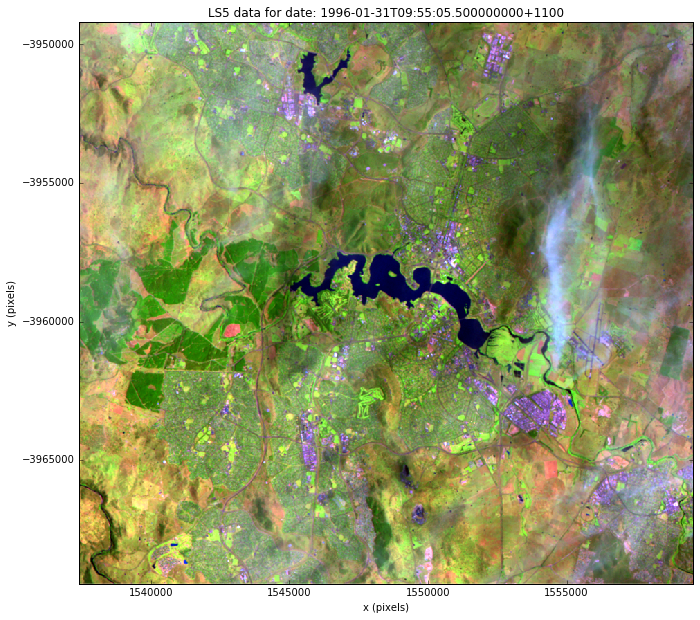

In [25]:
cur_date = L5data.isel(time=date_ind).coords['time'].values
xvec = L5data.isel(time=date_ind).coords['x'].values
yvec = L5data.isel(time=date_ind).coords['y'].values
plt.imshow(FC_image, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
#plt.axis('image')
plt.title('LS5 data for date: {}'.format(cur_date))
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')

Hmmm, some low-quality pixels here. We'll have to deal with that at some stage...

**Data access method 3:** `get_dataset()` is a convenience fuction (similar to `get_data_array()`) returning the data of the query as an `xarray.Dataset` object.

This time, let's only load up the desired bands (note that this can also probably be achieved with the earlier methods):

In [26]:
L5data = dc.get_dataset(product='NBAR', platform='LANDSAT_5', x=(149.0, 149.22), y=(-35.22, -35.38), 
                        dimensions={'time': {'range': ((1996, 1, 1), (1996, 7 ,1)) }},
                        variables=['band_20', 'band_40', 'band_50'])

In [27]:
print( L5data )

<xarray.Dataset>
Dimensions:  (time: 11, x: 887, y: 812)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-30T22:54:41.500000 ...
  * y        (y) float64 -3.949e+06 -3.949e+06 -3.949e+06 -3.949e+06 ...
  * x        (x) float64 1.537e+06 1.537e+06 1.537e+06 1.537e+06 1.538e+06 ...
Data variables:
    band_50  (time, y, x) int16 2261 2271 2346 2403 2460 2404 2506 2585 2608 ...
    crs      int64 0
    band_40  (time, y, x) int16 2368 2372 2375 2450 2513 2438 2651 2894 2995 ...
    band_20  (time, y, x) int16 985 989 990 1038 1062 1052 1108 1166 1123 ...
Attributes:
    source: This data is a reprojection and retile of Landsat surface reflectance scene data available from /g/data/rs0/scenes/
    summary: These files are experimental, short lived, and the format will change.
    product_version: 0.0.0
    license: Creative Commons Attribution 4.0 International CC BY 4.0
    title: Experimental Data files From the Australian Geoscience Data Cube - DO NOT USE


The following will keep the time dimension in each band. Subsequent band arithmetics would then apply to each date separately (we could even update our scaling function to properly handle the variable types to achieve this).

In [28]:
B2data = L5data.band_20
B4data = L5data.band_40
B5data = L5data.band_50
print ( B2data )

<xarray.DataArray 'band_20' (time: 11, y: 812, x: 887)>
dask.array<getitem..., shape=(11, 812, 887), dtype=int16, chunksize=(11, 812, 887)>
Coordinates:
  * time     (time) datetime64[ns] 1996-01-30T22:54:41.500000 ...
  * y        (y) float64 -3.949e+06 -3.949e+06 -3.949e+06 -3.949e+06 ...
  * x        (x) float64 1.537e+06 1.537e+06 1.537e+06 1.537e+06 1.538e+06 ...


Scaling the data using `scale_array()` still needs to be applied to the values themselves, rather than the `xarray.DataArray` variable...

In [29]:
date_ind = 4
sB2data = scale_array(B2data.isel(time=date_ind).values, 99.0, 0, 255, -999)
sB4data = scale_array(B4data.isel(time=date_ind).values, 99.0, 0, 255, -999)
sB5data = scale_array(B5data.isel(time=date_ind).values, 99.0, 0, 255, -999)

In [30]:
y_size = len(L5data.y)
x_size = len(L5data.x)
FC_image = np.zeros((y_size, x_size, 3), dtype='uint8')
FC_image[:,:,0] = sB5data
FC_image[:,:,1] = sB4data
FC_image[:,:,2] = sB2data

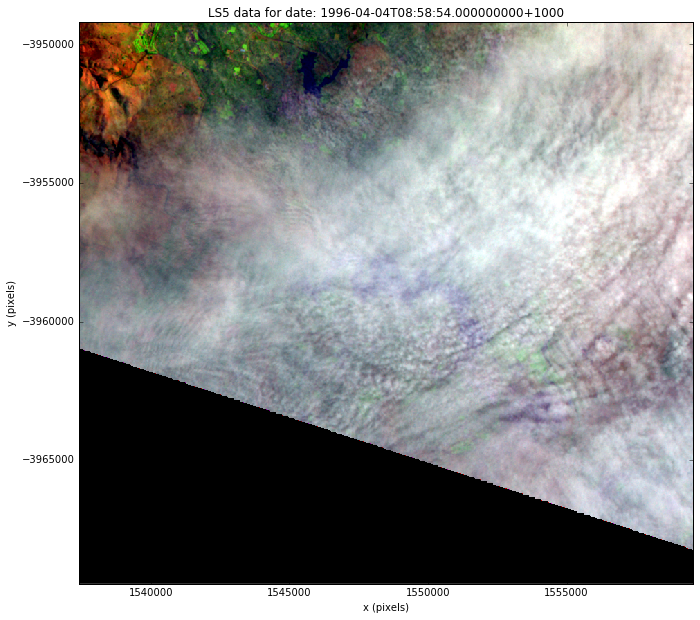

In [31]:
cur_date = L5data.time[date_ind].values
xvec = L5data.x.values
yvec = L5data.y.values
plt.imshow(FC_image, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
#plt.axis('image')
plt.title('LS5 data for date: {}'.format(cur_date))
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')

## Recap
So, in this notebook, we have learnt about how to:

* gain a basic familiarity with the AGDC v2.0 API functions
* query the AGDC database and check for available datasets
* access the AGDC (Landsat 5) data for a given geographical region and date
* use the data to create some pretty plots.

Stay tuned for more! Coming up next:

* dealing with the PQ flags also available in the AGDC database (e.g. mask for clouds and shadows)
* accessing the WOFS datasets and using the data to mask non-water regions
* performing basic band math on the Landsat data
* and more...
